###Import all Library

In [48]:
!pip install wandb
!pip install wordcloud
!pip install colour
## Installing font for Hindi for matplotlib ##
!apt-get install -y fonts-lohit-deva
!fc-list :lang=hi family
import os
import random
import time
import wandb
import re, string
import numpy as np
import pandas as pd 
import matplotlib as mpl
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from colour import Color
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from matplotlib.font_manager import FontProperties
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-lohit-deva is already the newest version (2.95.4-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Lohit Devanagari


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [77]:
########################### CREATING DATASET ###################################
def creating_data(language,path = "/content/drive/MyDrive/dakshina_dataset_v1.0/{}/lexicons/{}.translit.sampled.{}.tsv"):
    #returning train tsv, val tsv, test tsv
    return path.format(language, language, "train"), path.format(language, language, "dev"), path.format(language, language, "test")
## functions for preprocessing data ##

def add_start_end_tokens(df, cols, sos="\t", eos="\n"):
    def add_tokens(s):  
        # \t = starting token
        # \n = ending token
        return sos + str(s) + eos

    for col in cols:
        df[col] = df[col].apply(add_tokens) 
    
def tokenize(lang, tokenizer=None):
    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)

        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')                                                           
    else: 
        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')                                                         
    return lang_tensor, tokenizer

def preprocess_data(fpath, input_lang_tokenizer=None, targ_lang_tokenizer=None):   
    df = pd.read_csv(fpath, sep="\t", header=None)
    add_start_end_tokens(df, [0,1])# adding start and end tokens to know when to stop predicting   
    input_lang_tensor, input_tokenizer = tokenize(df[1].astype(str).tolist(),tokenizer=input_lang_tokenizer)                                                 
    targ_lang_tensor, targ_tokenizer = tokenize(df[0].astype(str).tolist(),tokenizer=targ_lang_tokenizer)                                                   
    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset)) 
    return dataset, input_tokenizer, targ_tokenizer

# Model Building

In [78]:
#########################  LAYER TYPE ##########################################
def model_layer_type(name, units, dropout, return_state=False, return_sequences=False):
    temp = layers.GRU(units=units, dropout=dropout, return_state=return_state, return_sequences=return_sequences)    
    if name=="rnn":
      temp = layers.SimpleRNN(units=units, dropout=dropout, return_state=return_state, return_sequences=return_sequences)
    elif name == 'lstm':
      temp = layers.LSTM(units=units, dropout=dropout, return_state=return_state, return_sequences=return_sequences)
    return temp

###Encoder Class

In [79]:
def create_layer_for_Enc(no_of_layer, layer_type, units, dropout):
  temp = []
  for i in range(no_of_layer):
    ly = model_layer_type(layer_type, units, dropout, return_state=True, return_sequences=True)
    temp.append(ly)
  return temp

class Encoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, encoder_vocab_size, embedding_dim, dropout):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(encoder_vocab_size, embedding_dim)
        self.dropout = dropout
        self.n_layers = n_layers
        self.units = units
        self.layer_type = layer_type
        self.rnn_layers = create_layer_for_Enc(self.n_layers, self.layer_type, self.units, self.dropout)
        
    def call(self, x, hidden):
      pass
        
    def Enc_out_state(self, x, hidden):
        x = self.embedding(x)
        x = self.rnn_layers[0](x, initial_state=hidden)
        temp = self.rnn_layers[1:]
        for layer in temp:
            x = layer(x)
        return x[0], x[1:]

    def initialize_hidden_state(self, batch_size):
        if self.layer_type != "lstm":
            return [tf.zeros((batch_size, self.units))]
        else:
            return [tf.zeros((batch_size, self.units))]*2

###Decoder Class

In [80]:
#create_layer_for_De
def create_layer_for_Dec(no_of_layer, layer_type, units, dropout):
  temp = [] 
  for i in range(no_of_layer):            
    if i == no_of_layer-1:
      ly = model_layer_type(layer_type, units, dropout,return_sequences=False,return_state=True)
    else:
      ly = model_layer_type(layer_type, units, dropout,return_sequences=True,return_state=True)
    temp.append(ly)
  return temp

class Decoder(tf.keras.Model):
    def __init__(self, type_of_layer, Total_layers, units,vocab_size, embed_dim, dropout, attention=False):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(vocab_size, activation="softmax") 
        self.n_layers = Total_layers
        self.units = units
        self.layer_type = type_of_layer
        self.dropout = dropout
        self.flatten = layers.Flatten() 
        self.rnn_layers = create_layer_for_Dec(self.n_layers, self.layer_type, self.units, self.dropout)
        self.embed_layer = layers.Embedding(input_dim=vocab_size,output_dim=embed_dim)           
        self.attention = attention
        if self.attention:
            self.attention_layer = BahdanauAttention(self.units)

    def call(self, x, hidden, enc_out=None):
        pass
    def Dec_pred_state(self, x, hidden, enc_out=None):        
        x = self.embed_layer(x)
        if self.attention:
            context_vector, attention_weights = self.attention_layer(hidden,enc_out)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        else:
            attention_weights = None
        x = self.rnn_layers[0](x, initial_state=hidden)
        temp = self.rnn_layers[1:]
        for layer in temp:
            x = layer(x)
        return self.dense(self.flatten(x[0])), x[1:], attention_weights

    
                                            

###BahdanauAttention

In [81]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  def call(self, enc_state, enc_out): 
    enc_state = tf.concat(enc_state, 1)
    enc_state = tf.expand_dims(enc_state, 1)
    score = self.V(tf.nn.tanh(self.W1(enc_state) + self.W2(enc_out)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * enc_out
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights
                                  

###BeamSearch

In [82]:
class BeamSearch():
    def __init__(self, model, k):
        self.k = k 
        self.model = model
        self.acc = tf.keras.metrics.Accuracy()
    def sample_beam_search(self, probs):
        m, n = probs.shape
        output_sequences = [[[], 0.0]]
        for row in probs:
            beams = []
            for tup in output_sequences:
                seq, score = tup
                for j in range(n):
                    new_beam = [seq + [j], score - tf.math.log(row[j])]
                    beams.append(new_beam)
            output_sequences = sorted(beams, key=lambda x: x[1])[:self.k]
        tensors, scores = list(zip(*output_sequences))
        tensors = list(map(lambda x: tf.expand_dims(tf.constant(x),0), tensors))
        return tf.concat(tensors, 0), scores
    def beam_accuracy(self, input, target):
        accs = []

        for i in range(self.k):
            self.acc.reset_states()
            self.acc.update_state(target, input[i, :])  
            accs.append(self.acc.result())

        return max(accs)
    
    def step(self, input, target, enc_state):

        batch_acc = 0
        sequences = []

        enc_out, enc_state = self.model.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*self.model.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        for i in range(target.shape[0]):

            possibilities, scores = self.sample_beam_search(sequences[i, :, :])
            batch_acc += self.beam_accuracy(possibilities, target[i, 1:])

        batch_acc = batch_acc / target.shape[0]

        return 0, batch_acc

    def evaluate(self, test_dataset, batch_size=None, upto=5, use_wandb=False):
        
        if batch_size is not None:
            self.model.batch_size = batch_size
            test_dataset = test_dataset.batch(batch_size)
        else:
            self.model.batch_size = 1

        test_acc = 0
        enc_state = self.model.encoder.initialize_hidden_state(self.model.batch_size)

        for batch, (input, target) in enumerate(test_dataset.take(upto)):
           
           _, acc = self.step(input, target, enc_state)
           test_acc += acc

        if use_wandb:
            wandb.log({"test acc (beam search)": test_acc / upto})
        print(f"Test Accuracy on {upto*batch_size} samples: {test_acc / upto:.4f}\n")
    def translate(self, word):

        word = "\t" + word + "\n"
        sequences = []
        result = []

        inputs = self.model.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.model.max_input_len,
                                                               padding="post")


        enc_state = self.model.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.model.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.model.max_target_len):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        possibilities, scores = self.sample_beam_search(tf.squeeze(sequences, 0))
        output_words = self.model.targ_tokenizer.sequences_to_texts(possibilities.numpy())
        
        def post_process(word):
            word = word.split(" ")[:-1]
            return "".join([x for x in word])

        output_words = list(map(post_process, output_words))

        return output_words, scores

In [122]:
class Seq2SeqModel():
    def __init__(self,embed_dim, enc_layers, dec_layers, type_layer, units, dropout,loss, optimizer, metric, attention=False):
        self.embed_dim = embed_dim
        self.enc_layers = enc_layers
        self.attention = attention
        self.dec_layers = dec_layers
        self.units = units
        self.dropout = dropout
        self.stats = []
        self.batch_size = 128
        self.type_layer = type_layer
        self.units = units
        self.dropout = dropout
        self.use_beam_search = False
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    
    
    def create_model(self):
        self.encoder = Encoder(self.type_layer, self.enc_layers, self.units, len(self.input_tokenizer.word_index) + 1, self.embed_dim, self.dropout)
        self.decoder = Decoder(self.type_layer, self.dec_layers, self.units, len(self.targ_tokenizer.word_index) + 1, self.embed_dim,  self.dropout, self.attention)                            
    
    @tf.function
    def train_step(self, input, target, enc_state):
        loss = 0 
        with tf.GradientTape() as tape: 
            enc_out, enc_state = self.encoder.Enc_out_state(input, enc_state)
            dec_input, dec_state = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1), enc_state
            for t in range(target.shape[1]-1):
                    x = t+1
                    preds, dec_state, _ = self.decoder.Dec_pred_state(dec_input, dec_state, enc_out)
                    self.metric.update_state(target[:,x], preds)
                    loss = loss + self.loss(target[:,x], preds)                    
                    dec_input = tf.expand_dims(target[:,x], 1) 

            if random.random() < self.teacher_forcing_ratio:    
               pass
            else:
                preds = tf.argmax(preds, 1)
                dec_input = tf.expand_dims(preds, 1)

            gradients = tape.gradient(loss, self.encoder.variables + self.decoder.variables)
            self.optimizer.apply_gradients(zip(gradients, self.encoder.variables + self.decoder.variables))
        return loss / target.shape[1], self.metric.result()  #return batch_loss


    @tf.function
    def validation_step(self, input, target, enc_state):
        loss = 0  
        enc_out, enc_state = self.encoder.Enc_out_state(input, enc_state)
        dec_input, dec_state = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1), enc_state
        for t in range(target.shape[1]-1):
            preds, dec_state, _ = self.decoder.Dec_pred_state(dec_input, dec_state, enc_out)
            loss = loss + self.loss(target[:,t+1], preds)
            self.metric.update_state(target[:,t+1], preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)        
        return loss / target.shape[1], self.metric.result() #returning batch_size


    def fit(self, dataset, validation_dataset, batch_size=128, epochs=5, use_wandb=False, teacher_forcing_ratio=1.0):
        self.batch_size = batch_size        
        steps_per_epoch = len(dataset) // self.batch_size
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        sample_inp, sample_targ = next(iter(dataset))
        steps_per_epoch_val = len(validation_dataset) // self.batch_size        
        val_dataset = validation_dataset.batch(self.batch_size, drop_remainder=True)        
        self.max_input_len, self.max_target_len = sample_inp.shape[1],sample_targ.shape[1]
        self.teacher_forcing_ratio = teacher_forcing_ratio
        print("------------------------------------------------------------------------------------------------------------------------------------------")
        for epoch in range(1, epochs+1):
            print(f"Epochs {epoch}\n")
            ## Training loop ##
            total_loss = 0
            total_acc = 0
            self.metric.reset_states()
            starting_time = time.time()  
            if self.type_layer != "lstm":
              enc_state = [tf.zeros((batch_size, self.units))]
            else:
              enc_state = [tf.zeros((batch_size, self.units))]*2
            print("Training .....\n")
            for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
                loss, acc = self.train_step(input, target, enc_state)
                total_loss = total_loss + loss
                total_acc = total_acc + acc                                
                if (batch+1) % 100 == 0:
                    print(f"Batch {batch+1} Loss {loss:.4f}")
                if batch==0:
                    print(f"Batch {batch+1} Loss {loss:.4f}")  
            avg_acc = total_acc / steps_per_epoch
            avg_loss = total_loss / steps_per_epoch 
            # Validation loop ##
            self.metric.reset_states()

            if self.type_layer != "lstm":
              enc_state = [tf.zeros((batch_size, self.units))]
            else:
              enc_state = [tf.zeros((batch_size, self.units))]*2
            total_val_acc = 0
            total_val_loss = 0
            print("\nValidating ...")
            for batch, (input, target) in enumerate(val_dataset.take(steps_per_epoch_val)):
                loss, acc = self.validation_step(input, target, enc_state)
                total_val_loss = total_val_loss + loss
                total_val_acc = total_val_acc + acc

            print(f"\nTrain Loss: {avg_loss} Train Accuracy: {avg_acc*100} Validation Loss: { total_val_loss / steps_per_epoch_val} Validation Accuracy: {(total_val_acc / steps_per_epoch_val)*100}")
            time_taken = time.time() - starting_time
            self.stats.append({"epoch": epoch,
                            "train loss": avg_loss,
                            "val loss": total_val_loss / steps_per_epoch_val,
                            "train acc": avg_acc*100,
                            "val acc": (total_val_acc / steps_per_epoch_val)*100,
                            "training time": time_taken})
            
            if use_wandb:
                wandb.log(self.stats[-1])
            
            print(f"\nTime taken for the epoch {time_taken:.4f}")
            print("------------------------------------------------------------------------------------------------------------------------------------------") 
        print("\nModel trained successfully !!")
        
    def evaluate(self, test_dataset, batch_size=None):

        if batch_size is not None:
            self.batch_size = batch_size

        test_steps_per_epoch = len(test_dataset) // batch_size
        test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
        
        total_test_loss = 0
        total_test_accuracy = 0
        self.metric.reset_states()

        enc_state = self.encoder.initialize_hidden_state(self.batch_size)

        print("\nRunning Model on the Test dataset .....\n")
        for batch, (input, target) in enumerate(test_dataset.take(test_steps_per_epoch)):
            batch_loss, acc = self.validation_step(input, target, enc_state)
            total_test_loss += batch_loss
            total_test_accuracy += acc

        test_acc = total_test_accuracy / test_steps_per_epoch
        test_loss = total_test_loss / test_steps_per_epoch
    
        print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

        return test_loss,test_acc
    def translate(self, word, get_heatmap=False):

        word = "\t" + word + "\n"

        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=self.max_input_len, padding="post")                                                                                                                         
        result = ""
        att_wts = []

        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder.Enc_out_state(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.max_target_len):
            preds, dec_state, attention_weights = self.decoder.Dec_pred_state(dec_input, dec_state, enc_out)       
            if get_heatmap:
                att_wts.append(attention_weights)    
            preds = tf.argmax(preds, 1)
            next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char
            dec_input = tf.expand_dims(preds, 1)
            if next_char == "\n":
                return result[:-1], att_wts[:-1]
        return result[:-1], att_wts[:-1]

    def plot_attention_heatmap(self, word, ax, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

        translated_word, attn_wts = self.translate(word, get_heatmap=True)
        attn_heatmap = tf.squeeze(tf.concat(attn_wts, 0), -1).numpy()

        input_word_len = len(word)
        output_word_len = len(translated_word)

        ax.imshow(attn_heatmap[:, :input_word_len])

        font_prop = FontProperties(fname=font_path, size=18)

        ax.set_xticks(np.arange(input_word_len))
        ax.set_yticks(np.arange(output_word_len))

        ax.set_xticklabels(list(word))
        ax.set_yticklabels(list(translated_word), fontproperties=font_prop)


# Visualizing Model Outputs

In [85]:
class Coloring():
    def __init__(self, word_color, color_default):
       
        self.word_color = word_color
        self.color_default = color_default
    def __call__(self, word, **kwargs):
        return self.word_color.get(word, self.color_default)

In [86]:
#get_color
def get_colors(inputs, targets, preds):
    n = len(targets)
    smoother = SmoothingFunction().method2
    def get_scores(target, output, smoother):
        return sentence_bleu(list(list(target)), list(output), smoothing_function=smoother)
    red = Color("red")
    colors = list(red.range_to(Color("violet"),n))
    colors = list(map(lambda c: c.hex, colors))
    scores = []
    for i in range(n):
        scores.append(get_scores(targets[i], preds[i], smoother))
    d = dict(zip(sorted(scores), list(range(n))))
    ordered_colors = list(map(lambda x: colors[d[x]], scores))  
    input_colors = dict(zip(inputs, ordered_colors))
    target_colors = dict(zip(targets, ordered_colors))
    pred_colors = dict(zip(preds, ordered_colors))
    return input_colors, target_colors, pred_colors


In [87]:
#visualize_model_outputs
def visualize_model_outputs(model, test_file=creating_data("hi")[2], n=10, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):
    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    inputs = df[1].astype(str).tolist()
    targets = df[0].astype(str).tolist()
    preds = list(map(lambda word: model.translate(word)[0], inputs))
    input_colors, target_colors, pred_colors =  get_colors(inputs, targets, preds)# Generate colors for the words
    color_fn_ip = Coloring(input_colors, "white")
    color_fn_tr = Coloring(target_colors, "white")
    color_fn_op = Coloring(pred_colors, "white")
    input_text = Counter(inputs)
    target_text = Counter(targets)
    output_text = Counter(preds)
    fig, axs = plt.subplots(1,3, figsize=(30, 15))
    plt.tight_layout()
    wc_in = WordCloud(random_state=1).generate_from_frequencies(input_text)
    wc_out = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(output_text)
    wc_tar = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(target_text)
    axs[0].set_title("Input words", fontsize=30)
    axs[0].imshow(wc_in.recolor(color_func=color_fn_ip))
    axs[1].set_title("Target words", fontsize=30)
    axs[1].imshow(wc_tar.recolor(color_func=color_fn_tr))
    axs[2].set_title("Model Prediction Words", fontsize=30)
    axs[2].imshow(wc_out.recolor(color_func=color_fn_op))
    plt.show()
    

In [88]:
def Evaluating_Random_words(model, test_file=creating_data("hi")[2], n=10):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    print(f"Arbitrarily evaluating the model on {n} words\n")
    for i in range(n):
        word = str(df[1][i])
        print(f"Input word: {word}")
        print(f"Actual translation of the word: {str(df[0][i])}")
        print(f"Model translation of the word: {model.translate(word)[0]}\n")


In [120]:
def Test_Model(lang, embed_dim, enc_layers, dec_layers, type_layer, units, dropout, attention, teacher_forcing_ratio=1.0, epch =20,save_outputs=None):
    TRAIN_TSV, VAL_TSV, TEST_TSV = creating_data(lang)
    model = Seq2SeqModel(embed_dim,enc_layers, dec_layers, type_layer,units,dropout, tf.keras.losses.SparseCategoricalCrossentropy(),tf.keras.optimizers.Adam(),tf.keras.metrics.SparseCategoricalAccuracy(),attention)                                                                                                                                                                                      
    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)
    model.input_tokenizer = input_tokenizer
    model.targ_tokenizer = targ_tokenizer
    model.create_model()
    model.fit(dataset, val_dataset, epochs=10, use_wandb=False, teacher_forcing_ratio=teacher_forcing_ratio)

    # Character accuracy
    test_dataset, _, _ = preprocess_data(TEST_TSV, model.input_tokenizer, model.targ_tokenizer)
    test_loss, test_acc = model.evaluate(test_dataset, batch_size=100)

    #  Word accuracy #
    test_tsv = pd.read_csv(TEST_TSV, sep="\t", header=None)
    inputs = test_tsv[1].astype(str).tolist()
    targets = test_tsv[0].astype(str).tolist()
    
    outputs = []

    for word in inputs:
        outputs.append(model.translate(word)[0])

    def word_level_acc(outputs, targets):
        return np.sum(np.asarray(outputs) == np.array(targets)) / len(outputs)

    word_acc = word_level_acc(outputs, targets)
    print(f"Word level accuracy: {word_acc}")
    
    #wandb.log({"Word-Accuracy":word_acc})

    #if save_outputs is None:
    df = pd.DataFrame()
    df["inputs"] = inputs
    df["targets"] = targets
    df["outputs"] = outputs
    df.to_csv('/content/drive/MyDrive/dakshina_dataset_v1.0/pred_attention.csv')


# Q6 Visualizing Model Connectivity

In [90]:
# Tools for getting model connectivity between input and output characters
def get_lstm_output(decoder, x, hidden, enc_out=None):
    
    x = decoder.embed_layer(x)

    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None

    x = decoder.rnn_layers[0](x, initial_state=hidden)

    for layer in decoder.rnn_layers[1:]:
        x = layer(x)

    output, state = x[0], x[1:]

    #output = decoder.dense(decoder.flatten(output))
    
    return output, state, attention_weights

def get_output_from_embedding(encoder, x, hidden):

    x = encoder.rnn_layers[0](x, initial_state=hidden)    
    for layer in encoder.rnn_layers[1:]:
        x = layer(x)
    output, state = x[0], x[1:]
    return output, state
def get_connectivity(model, word):
    word = "\t" + word + "\n"
    inputs = model.input_tokenizer.texts_to_sequences([word])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,maxlen=model.max_input_len,padding="post")                                                                                                                     
    result = ""
    gradient_list = []
    enc_state = model.encoder.initialize_hidden_state(1)
    embedded_in = model.encoder.embedding(inputs)
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        tape.watch(embedded_in)

        enc_out, enc_state = get_output_from_embedding(model.encoder, embedded_in, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, model.max_target_len):

            lstm_out, dec_state, _ = get_lstm_output(model.decoder, dec_input, dec_state, enc_out)

            preds = model.decoder.dense(model.decoder.flatten(lstm_out))
            gradient_list.append(tape.gradient(lstm_out, embedded_in)[0])
            
            preds = tf.argmax(preds, 1)
            next_char = model.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], gradient_list[:-1]

        return result[:-1], gradient_list[:-1]

In [91]:
# Imports for visualising the model connectivity
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from IPython.display import HTML as html_print
from IPython.display import display
import tensorflow.keras.backend as K

# get html element
def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
      '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
      '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
      '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = int(value * 19)
    if value == 19:
        value -= 1
    return colors[value]

# sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x)) 
    return z

def softmax(x):
    v = np.exp(x)
    v = v / np.sum(v)
    return v

def get_gradient_norms(grad_list, word, activation="sigmoid"):
    grad_norms = []
    for grad_tensor in grad_list:
        grad_mags = tf.norm(grad_tensor, axis=1)
        grad_mags = grad_mags[:len(word)]
        if activation == "softmax":
            grad_mags_scaled = softmax(grad_mags)
        elif activation == "scaler":
            scaler = MinMaxScaler()
            grad_mags = tf.reshape(grad_mags, (-1,1))
            grad_mags_scaled = scaler.fit_transform(grad_mags)
        else:
            grad_mags_scaled = sigmoid(grad_mags)
        grad_norms.append(grad_mags_scaled)
    return grad_norms

def visualize(grad_norms, word, translated_word):
    print("Actual Word:", word)
    print("Transliterated Word:", translated_word)
    for i in range(len(translated_word)):
        print("Visualization for", translated_word[i],":")
        text_colours = []
        for j in range(len(grad_norms[i])):
            text = (word[j], get_clr(grad_norms[i][j]))
            text_colours.append(text)
        print_color(text_colours)

def visualise_connectivity(model, word, activation="sigmoid"):
    translated_word, grad_list = get_connectivity(model, word)
    grad_norms = get_gradient_norms(grad_list, word, activation)
    visualize(grad_norms, word, translated_word)

In [123]:
model = Test_Model(lang="hi",embed_dim=256,enc_layers=3,dec_layers=3,type_layer="lstm",units=256,dropout=0.2,attention=True)                                                                                                                                                          

------------------------------------------------------------------------------------------------------------------------------------------
Epochs 1

Training .....

Batch 1 Loss 3.9865
Batch 100 Loss 1.0249
Batch 200 Loss 0.9009
Batch 300 Loss 0.8969

Validating ...

Train Loss: 1.0409018993377686 Train Accuracy: 68.68141174316406 Validation Loss: 3.1725053787231445 Validation Accuracy: 43.80744171142578

Time taken for the epoch 128.0821
------------------------------------------------------------------------------------------------------------------------------------------
Epochs 2

Training .....

Batch 1 Loss 0.8422
Batch 100 Loss 0.7658
Batch 200 Loss 0.7113
Batch 300 Loss 0.5850

Validating ...

Train Loss: 0.7134098410606384 Train Accuracy: 76.6253662109375 Validation Loss: 2.155086040496826 Validation Accuracy: 59.87984085083008

Time taken for the epoch 34.6958
---------------------------------------------------------------------------------------------------------------------

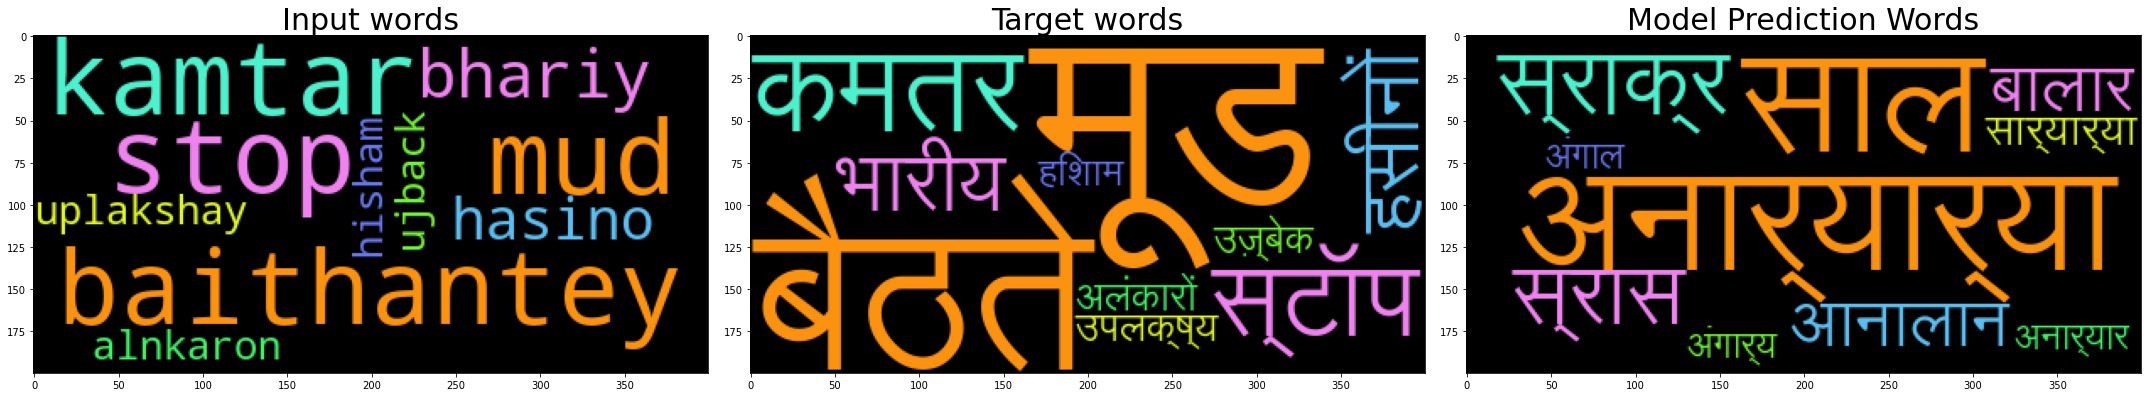

In [71]:
visualize_model_outputs(model, n=10)

In [72]:
def get_test_words(n):
    test_df = pd.read_csv(creating_data("hi")[2])
    test_sample = test_df.sample(n)
    test_sample.reset_index(inplace=True, drop=True)
    test_words = []
    for i in test_sample.index:
        entry = test_sample["अंक\tank\t5"].loc[i]
        parts = entry.split("\t")
        word = parts[1]
        test_words.append(word)
    return test_words

test_words = get_test_words(5)
print(test_words)

['batlaae', 'maine', 'semen', 'pahno', 'safety']


In [73]:
for word in test_words:
    visualise_connectivity(model, word, activation="scaler")

Actual Word: batlaae
Transliterated Word: आनालान
Visualization for आ :


Visualization for न :


Visualization for ा :


Visualization for ल :


Visualization for ा :


Visualization for न :


Actual Word: maine
Transliterated Word: आलाली
Visualization for आ :


Visualization for ल :


Visualization for ा :


Visualization for ल :


Visualization for ी :


Actual Word: semen
Transliterated Word: स्राल
Visualization for स :


Visualization for ् :


Visualization for र :


Visualization for ा :


Visualization for ल :


Actual Word: pahno
Transliterated Word: बाला
Visualization for ब :


Visualization for ा :


Visualization for ल :


Visualization for ा :


Actual Word: safety
Transliterated Word: स्राली
Visualization for स :


Visualization for ् :


Visualization for र :


Visualization for ा :


Visualization for ल :


Visualization for ी :


In [76]:
Evaluating_Random_words(model, n=5)

Arbitrarily evaluating the model on 5 words

Input word: cheh
Actual translation of the word: छह
Model translation of the word:  बाल

Input word: sheling
Actual translation of the word: शेलिंग
Model translation of the word:  अंग्राल

Input word: pammu
Actual translation of the word: पम्मी
Model translation of the word:  स्राल

Input word: nikalegi
Actual translation of the word: निकलेगी
Model translation of the word:  अनार्यां

Input word: ilaaj
Actual translation of the word: इलाज
Model translation of the word:  आलाल



# WandB Run

In [64]:
wandb.login()

True

In [65]:
def Train_Our_Model(lang, test_beam_search=False):

    config_defaults = {"embeded_dim": 64, 
                       "Teacher_forcing_ratio": 1.0,
                       "type_of_Layer": "lstm",
                       "decorder_encoder_layers": 1,
                       "units": 128,
                       "dropout": 0.1,
                       "Attention": False,
                       "Beam_width": 3,
                       "epochs":15
                       }

    wandb.init(config=config_defaults, project="CS6910_VM_Assignment_132", resume=True)

    ## 1. SELECT lang ##
    TRAIN_TSV, VAL_TSV, TEST_TSV = creating_data(lang)


    ## 2. DATA PREPROCESSING ##
    dataframe = pd.read_csv(TRAIN_TSV, sep="\t", header=None)
    def add_tokens(s, sos="\t", eos="\n"):  
        return sos + str(s) + eos    
    cols = [0,1]
    for col in cols:
        dataframe[col] = dataframe[col].apply(add_tokens)
    
    tokenizer = None
    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(dataframe[1].astype(str).tolist())
    lang_tensor = tokenizer.texts_to_sequences(dataframe[1].astype(str).tolist())
    lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')      
    input_lang_tensor, input_tokenizer = lang_tensor, tokenizer

    tokenizer = None
    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(dataframe[0].astype(str).tolist())
    lang_tensor = tokenizer.texts_to_sequences(dataframe[0].astype(str).tolist())
    lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')

    targ_lang_tensor, targ_tokenizer = lang_tensor, tokenizer
    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset))    
    
    dataframe = pd.read_csv(VAL_TSV, sep="\t", header=None)
    def add_tokens(s, sos="\t", eos="\n"):  
        return sos + str(s) + eos    
    cols = [0,1]
    for col in cols:
        dataframe[col] = dataframe[col].apply(add_tokens)
    lang_tensor = tokenizer.texts_to_sequences(dataframe[1].astype(str).tolist())
    lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')    
    input_lang_tensor = lang_tensor

    lang_tensor = tokenizer.texts_to_sequences(dataframe[0].astype(str).tolist())
    lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')
    targ_lang_tensor = lang_tensor
    val_dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    val_dataset = dataset.shuffle(len(val_dataset))

    ## 3. CREATING THE MODEL ##
    model = Seq2SeqModel(embed_dim=wandb.config.embeded_dim,enc_layers=wandb.config.decorder_encoder_layers,dec_layers=wandb.config.decorder_encoder_layers, type_layer=wandb.config.type_of_Layer, units=wandb.config.units,dropout=wandb.config.dropout,loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metric = tf.keras.metrics.SparseCategoricalAccuracy(),attention=wandb.config.Attention)                                                                                                                                                    
    ## 4. COMPILING THE MODEL 
    model.input_tokenizer = input_tokenizer
    model.targ_tokenizer = targ_tokenizer
    model.create_model()
    
    
    ## 5. FITTING AND VALIDATING THE MODEL
    model.fit(dataset, val_dataset, epochs=wandb.config.epochs, use_wandb=True, teacher_forcing_ratio=wandb.config.Teacher_forcing_ratio)

    if test_beam_search:
        ## OPTIONAL :- Evaluate the dataset using beam search and without beam search
        val_dataset, _, _ = preprocess_data(val_dataset, model.input_tokenizer, model.targ_tokenizer)
        subset = val_dataset.take(500)

        # a) Without beam search
        _, test_acc_without = model.evaluate(subset, batch_size=100) 
        wandb.log({"Test acc": test_acc_without})
        
        # b) With beam search
        beam_search = BeamSearch(model=model, k=wandb.config.beam_width)
        beam_search.evaluate(subset, batch_size=100, use_wandb=True)

# Sweeps with and without Attention

In [66]:
sweep_config = {
  "name": "Sweep_Assignment3",
  "method": "random",
  "parameters": {
        "decorder_encoder_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [64, 128, 256]
        },
        "type_of_Layer": {
            "values": ["gru", "rnn","lstm"]
        },
         "embeded_dim": {
            "values": [256,64, 128]
        },
        "dropout": {
            "values": [0.29, 0.37]
        },
        "Beam_width": {
            "values": [3, 7, 5]
        },
        "Teacher_forcing_ratio": {
            "values": [0.9, 0.5,0.2]
        },
        "Attention": {
            "values": [True,False]
        },
        "epochs":{
            "values":[10,20,30]
        }

    }
}

In [19]:
sweep_id = wandb.sweep(sweep_config, project="CS6910_VM_Assignment_132")

Create sweep with ID: dkj9y1c0
Sweep URL: https://wandb.ai/manishiitm/CS6910_VM_Assignment_132/sweeps/dkj9y1c0


In [67]:
wandb.agent(sweep_id, function=lambda: Train_Our_Model("hi"))

wandb: Agent Starting Run: 350ic9ot with config:
wandb: 	Attention: True
wandb: 	Beam_width: 3
wandb: 	Teacher_forcing_ratio: 0.2
wandb: 	decorder_encoder_layers: 3
wandb: 	dropout: 0.37
wandb: 	embeded_dim: 64
wandb: 	epochs: 20
wandb: 	type_of_Layer: gru
wandb: 	units: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Tried to auto resume run with id ngxitdn2 but id 350ic9ot is set.


------------------------------------------------------------------------------------------------------------------------------------------
EPOCH 1

Training .....

Batch 1 Loss 3.9941
Batch 100 Loss 1.1687
Batch 200 Loss 1.0621
Batch 300 Loss 1.0237

Validating ...

Train Loss: 1.2659486532211304 Train Accuracy: 65.74872589111328 Validation Loss: 1.4097137451171875 Validation Accuracy: 66.03125

Time taken for the epoch 126.6057
------------------------------------------------------------------------------------------------------------------------------------------
EPOCH 2

Training .....

Batch 1 Loss 0.9531


wandb: Ctrl + C detected. Stopping sweep.


### Question-8 finetune the GPT2 model to generate lyrics for English songs

In [94]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 31.2 MB/s 
     |████████████████████████████████| 6.6 MB 66.1 MB/s 
     |████████████████████████████████| 596 kB 63.3 MB/s 
     |████████████████████████████████| 77 kB 8.6 MB/s 
     |████████████████████████████████| 880 kB 62.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=f85ab7a9767afb455ae09cdbbcd4a127804ccd4a1dfc7be1671da7870f55ccb5
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


###Import all Library

In [95]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv

### Read CSV File

In [96]:
df = pd.read_csv("/content/genius_hip_hop_lyrics.csv",encoding = 'unicode_escape', engine ='python')
df.head()

,id,candidate,song,artist,sentiment,theme,album_release_date,line,url
0,1,Mike Huckabee,None Shall Pass,Aesop Rock,neutral,NaN,2011,"Wither by the watering hole, Border patrol / W...",http://genius.com/Aesop-rock-none-shall-pass-l...
1,2,Mike Huckabee,Wellstone,Soul Khan,negative,NaN,2012,Might find the door but never touch the key / ...,http://genius.com/Soul-khan-wellstone-lyrics
2,3,Jeb Bush,Awe,Dez & Nobs,neutral,NaN,2006,I heard Jeb Bush looking for a (inaudible),http://genius.com/Dez-and-nobs-awe-lyrics
3,4,Jeb Bush,The Truth,Diabolic,negative,political,2006,What you heard before ain't as big of a lesson...,http://genius.com/Diabolic-the-truth-lyrics
4,5,Jeb Bush,Money Man,Gorilla Zoe,negative,personal,2007,I'm comin back from Florida / Wit Jeb Bush and...,http://genius.com/Gorilla-zoe-money-man-lyrics


In [97]:
df = df[df['line'].apply(lambda x: len(x.split(' ')) < 350)]

In [98]:
class Lyrics_of_song(Dataset):
    
    def __init__(self, control_code, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.lyrics = []

        for row in df['line']:
          self.lyrics.append(torch.tensor(
                self.tokenizer.encode(f"<|{control_code}|>{row[:max_length]}<|endoftext|>")
            ))
                
        if truncate:
            self.lyrics = self.lyrics[:20000]
        self.lyrics_count = len(self.lyrics)
        
    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        return self.lyrics[item]

In [99]:
dataset = Lyrics_of_song(df['line'], truncate=True, gpt2_type="gpt2")

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [100]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

###Accumulated batch size 

In [101]:
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None


### Train Model

In [102]:
def train(dataset, model, tokenizer,batch_size=16, epochs=20, lr=2e-5,max_seq_len=400, warmup_steps=200, gpt2_type="gpt2", output_dir=".", output_prefix="wreckgar", test_mode=False,save_model_on_epoch=False,):              
    acc_steps = 100
    #entry_length is maximum number of words
    device=torch.device("cuda")
    model = model.cuda()
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1)        
    train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    loss=0
    accumulating_batch_count = 0
    input_tensor = None

    for epoch in range(epochs):

        print(f"Training Epoch {epoch+1}")
        print(loss)
        
        for idx, entry in tqdm(enumerate(train_dataloader)):
            if input_tensor is None:
                input_tensor = entry
                carry_on = True
                

            (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

            if carry_on and idx != len(train_dataloader) - 1:
                continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            loss.backward()

            if (accumulating_batch_count % batch_size) == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            accumulating_batch_count += 1
            input_tensor = None
        if save_model_on_epoch:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),
            )
    return model


In [103]:
model = train(dataset, model, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Training Epoch 1
0


377it [00:37, 10.13it/s]


Training Epoch 2
tensor(2.2088, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:38,  9.82it/s]


Training Epoch 3
tensor(2.0079, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:36, 10.19it/s]


Training Epoch 4
tensor(1.6698, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37,  9.99it/s]


Training Epoch 5
tensor(1.5486, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.01it/s]


Training Epoch 6
tensor(1.3704, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.06it/s]


Training Epoch 7
tensor(1.1021, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.00it/s]


Training Epoch 8
tensor(1.0003, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37,  9.99it/s]


Training Epoch 9
tensor(0.7119, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37,  9.99it/s]


Training Epoch 10
tensor(0.5175, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.01it/s]


Training Epoch 11
tensor(0.2949, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.05it/s]


Training Epoch 12
tensor(0.2630, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.06it/s]


Training Epoch 13
tensor(0.1720, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.06it/s]


Training Epoch 14
tensor(0.2543, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.05it/s]


Training Epoch 15
tensor(0.1602, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.06it/s]


Training Epoch 16
tensor(0.1100, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.04it/s]


Training Epoch 17
tensor(0.1292, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.01it/s]


Training Epoch 18
tensor(0.1710, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.01it/s]


Training Epoch 19
tensor(0.2058, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37, 10.01it/s]


Training Epoch 20
tensor(0.1676, device='cuda:0', grad_fn=<NllLossBackward0>)


377it [00:37,  9.98it/s]


###Generate List 

In [104]:
def List_generate(model,tokenizer, prompt,entry_count=10,entry_length=30,top_p=0.8, temperature=1.,):    
    model.eval()
    generated_num = 0
    generated_list = []

    filter_value = -float("Inf")

    with torch.no_grad():

        for entry_idx in trange(entry_count):

            entry_finished = False

            generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

            for i in range(entry_length):
                outputs = model(generated, labels=generated)
                loss, logits = outputs[:2]
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value

                next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token), dim=1)

                if next_token in tokenizer.encode("<|endoftext|>"):
                    entry_finished = True

                if entry_finished:

                    generated_num = generated_num + 1

                    output_list = list(generated.squeeze().numpy())
                    output_text = tokenizer.decode(output_list)
                    generated_list.append(output_text)
                    break
            
            if not entry_finished:
              output_list = list(generated.squeeze().numpy())
              output_text = f"{tokenizer.decode(output_list)}<|endoftext|>" 
              generated_list.append(output_text)  
    #return generated list            
    return generated_list

###Prompt: "I love Deep Learning"

In [105]:
x = List_generate(model.to('cpu'), tokenizer, "I love deep Learning", entry_count=1)

100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


In [106]:
print(x)

["I love deep Learning. The deep learning revolution has the potential to radically change the world. As of right now we still haven't been able to talk about the implications of<|endoftext|>"]


###Prompt: "I'm comin back from Florida / Wit Jeb Bush and."

In [107]:
x1 = List_generate(model.to('cpu'), tokenizer, "I'm comin back from Florida / Wit Jeb Bush and.", entry_count=1)

100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


In [108]:
print(x1)

["I'm comin back from Florida / Wit Jeb Bush and. Don't call me like a pussy / H-I'm Clinton and that bitch's runnin' / They're gon' have my back / See<|endoftext|>"]
